# DLMIA : Practical Work 1 - Melanoma Segmentation Task

Name : L'Haridon Emilien

Course : DLMIA - 24/25

# Import Required Libraries
Import necessary libraries such as TensorFlow, Keras, NumPy, and Matplotlib.

In [ ]:
# Import Required Libraries
# ML Libraries:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import backend as K

# Basic libraries
import os
import zipfile
import csv
from datetime import datetime
import requests

# Visualization Libraries
import matplotlib.pyplot as plt
import numpy as np

# Load and Preprocess Dataset
Load the ISIC 2016 dataset, preprocess the images and masks, and split the data into training and validation sets.

In [ ]:
def download_file(url, destination):
  """Downloads a file to the destination directory."""
  filename = os.path.basename(url)
  filepath = os.path.join(destination, filename)

  # Download the file
  response = requests.get(url, stream=True)
  with open(filepath, 'wb') as f:
    for chunk in response.iter_content(chunk_size=8192):
      if chunk:
        f.write(chunk)

  print(f"Downloaded {filename} to {destination}")

# URLs for the data and masks
data_url = 'https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part1_Training_Data.zip'
mask_url = 'https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part1_Training_GroundTruth.zip'

# Destination directory
destination = '/content/'

# Download the files
download_file(data_url, destination)
download_file(mask_url, destination)

Downloaded ISBI2016_ISIC_Part1_Training_Data.zip to /content/
Downloaded ISBI2016_ISIC_Part1_Training_GroundTruth.zip to /content/


In [ ]:
# Assuming the ZIP files are already downloaded and placed in the current directory
data_zip = '/content/ISBI2016_ISIC_Part1_Training_Data.zip'
mask_zip = '/content/ISBI2016_ISIC_Part1_Training_GroundTruth.zip'

with zipfile.ZipFile(data_zip, 'r') as zip_ref:
    zip_ref.extractall('data')

with zipfile.ZipFile(mask_zip, 'r') as zip_ref:
    zip_ref.extractall('masks')

# Baseline image preprocessing and network

First, create a baseline network based solely on the data without augmentation, and with default parameter.

In [ ]:
# Load and Preprocess Images
def load_images(image_dir, mask_dir, img_size=(128, 128)):
    """
    Load images and corresponding masks from specified directories, resize them, and normalize pixel values.

    Args:
        image_dir (str): Directory containing the images.
        mask_dir (str): Directory containing the masks.
        img_size (tuple): Target size for resizing the images and masks (default is (128, 128)).

    Returns:
        tuple: A tuple containing two numpy arrays:
            - images (np.array): Array of loaded and preprocessed images.
            - masks (np.array): Array of loaded and preprocessed masks.
    """
    images = []
    masks = []
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))

    for img_file, mask_file in zip(image_files, mask_files):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)

        img = load_img(img_path, target_size=img_size)
        img = img_to_array(img) / 255.0

        mask = load_img(mask_path, target_size=img_size, color_mode="grayscale")
        mask = img_to_array(mask) / 255.0
        mask = np.round(mask).astype(np.uint8)

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

# Directory and image size
image_dir = '/content/data/ISBI2016_ISIC_Part1_Training_Data'
mask_dir = '/content/masks/ISBI2016_ISIC_Part1_Training_GroundTruth'
img_size = (128, 128)

images, masks = load_images(image_dir, mask_dir, img_size)
x_train, x_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)



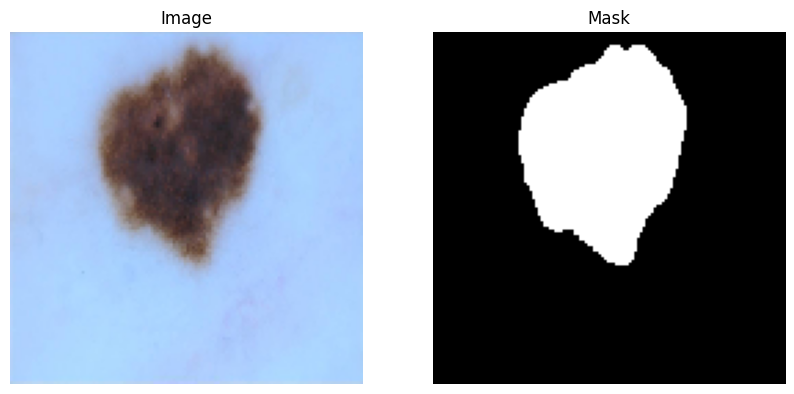

In [ ]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# Plot the image on the first subplot
axes[0].imshow(x_train[0])
axes[0].set_title('Image')
axes[0].axis('off')

# Plot the mask on the second subplot
axes[1].imshow(y_train[0].squeeze(), cmap='gray')
axes[1].set_title('Mask')
axes[1].axis('off')

# Display the figure
plt.show()

# Define U-Net Model
Define the U-Net model architecture using Keras. Adapt the input layer to match the dataset dimensions.

In [ ]:
# 4. Define U-Net Model
def unet_model(input_size=(128, 128, 3)):
    inputs = keras.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = keras.Model(inputs=[inputs], outputs=[outputs])
    return model


# Compile and Train the Model
Compile the U-Net model with appropriate loss function and optimizer. Train the model on the preprocessed dataset.

In [ ]:
# save history training value into a csv file
def save_training_history(history, filename_prefix='first_model', output_dir='/content/csv', more_metrics=False):
    """
    Helper function to save the training history of a model to a CSV file for later use or analysis purpose, particullary useful when running in Colab as the next session won't keep the variables
    """
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    # Get the current timestamp
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

    # Create the CSV filename with the timestamp
    csv_filename = f'{output_dir}/{filename_prefix}_{timestamp}.csv'

    # Save the training history to a CSV file
    with open(csv_filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        if more_metrics:
            writer.writerow(['epoch', 'loss', 'accuracy', 'val_loss', 'val_accuracy', 'sensitivity', 'f1_score', 'jaccard_index', 'dice_coefficient'])
        else:
            writer.writerow(['epoch', 'loss', 'accuracy', 'val_loss', 'val_accuracy'])
        for i in range(len(history.history['loss'])):
            if more_metrics:
                writer.writerow([i+1, history.history['loss'][i], history.history['accuracy'][i], history.history['val_loss'][i], history.history['val_accuracy'][i], history.history['sensitivity'][i], history.history['f1_score'][i], history.history['jaccard_index'][i], history.history['dice_coefficient'][i]])
            else:
                writer.writerow([i+1, history.history['loss'][i], history.history['accuracy'][i], history.history['val_loss'][i], history.history['val_accuracy'][i]])

    print(f"Training history saved to {csv_filename}")



In [ ]:
def plot_training_history(history):
    """
    Helper function to plot the accuracy, loss and jaccard index of a training
    """
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 3, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1,3,3)
    plt.plot(history.history['jaccard_index'])
    plt.plot(history.history['val_jaccard_index'])
    plt.title('Model Jaccard Index')
    plt.ylabel('Jaccard Index')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

# Visualize Results
Visualize the segmentation results by comparing the predicted masks with the ground truth masks.

In [ ]:
def visualize_predictions(images, masks, model, num=5):
    indices = np.random.choice(len(images), num)
    for i in indices:
        img = images[i]
        mask = masks[i]
        pred_mask = model.predict(np.expand_dims(img, axis=0))[0]
        pred_mask = (pred_mask > 0.5).astype(np.uint8)

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.title("Image")
        plt.imshow(img)
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title("True Mask")
        plt.imshow(mask.squeeze(), cmap='gray')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title("Predicted Mask")
        plt.imshow(pred_mask.squeeze(), cmap='gray')
        plt.axis('off')

        plt.show()

# Evaluate Baseline Model Performance
Evaluate the model's performance using metrics such as sensitivity, specificity, accuracy, Jaccard index, Dice coefficient, and ROC curve. (todo)

In [ ]:
# Define callbacks
callbacks = [
    ModelCheckpoint("melanoma_segmentation.keras", save_best_only=True),
    EarlyStopping(patience=10, restore_best_weights=True)
]

In [ ]:
# Let's define all the metrics asked for in the challenge as metrics to be used during training so we can follow them more easily as well as use them when evaluating the model
def sensitivity(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

# Create Precision object outside the function call
precision_metric = tf.keras.metrics.Precision()

def specificity(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    specificity = true_negatives / (possible_negatives + K.epsilon())
    return specificity

def f1_score(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')

    # True Positives, False Positives, False Negatives
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())

    f1 = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
    return f1

def jaccard_index(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=[1,2,3])
    jac = (intersection + K.epsilon()) / (sum_ - intersection + K.epsilon())
    return K.mean(jac)

def dice_coefficient(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=[1,2,3])
    dice = (2 * intersection + K.epsilon()) / (sum_ + K.epsilon())
    return K.mean(dice)

In [ ]:
# Function to compile the model with custom metrics
def compile_model_with_metrics(model, optimizer='adam', loss='binary_crossentropy'):
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy', sensitivity, specificity, f1_score, jaccard_index, dice_coefficient]
        )
    return model

In [ ]:
model_metrics = unet_model(input_size=(128, 128, 3))

# Compile the model with other metrics
model_metrics = compile_model_with_metrics(model_metrics)

# Train the model directly with x_train and y_train
history_metrics = model_metrics.fit(
    x_train, y_train,
    epochs=100,
    batch_size=16,
    validation_data=(x_val, y_val),
    callbacks=callbacks
)

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 71s 829ms/step - accuracy: 0.7312 - dice_coefficient: 0.2863 - f1_score: 0.0788 - jaccard_index: 0.1759 - loss: 0.5827 - sensitivity: 0.0632 - specificity: 0.9887 - val_accuracy: 0.8340 - val_dice_coefficient: 0.3934 - val_f1_score: 0.6204 - val_jaccard_index: 0.2563 - val_loss: 0.4187 - val_sensitivity: 0.5198 - val_specificity: 0.9453
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 273ms/step - accuracy: 0.8322 - dice_coefficient: 0.4545 - f1_score: 0.6317 - jaccard_index: 0.3113 - loss: 0.4144 - sensitivity: 0.5496 - specificity: 0.9416 - val_accuracy: 0.8419 - val_dice_coefficient: 0.4628 - val_f1_score: 0.6206 - val_jaccard_index: 0.3191 - val_loss: 0.3878 - val_sensitivity: 0.4947 - val_specificity: 0.9656
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 25s 386ms/step - accuracy: 0.8290 - dice_coefficient: 0.4744 - f1_score: 0.6283 - jaccard_index: 0.3291 - loss: 0.4192 - sensitivity: 0.5559 - specificity: 0.9377 - val_accuracy: 0.8498 - val_dice_coeffici

In [ ]:
model_metrics.save('/content/melanoma_segmentation_metrics.keras')

Training history saved to /content/csv/metrics_model_20241019_144616.csv


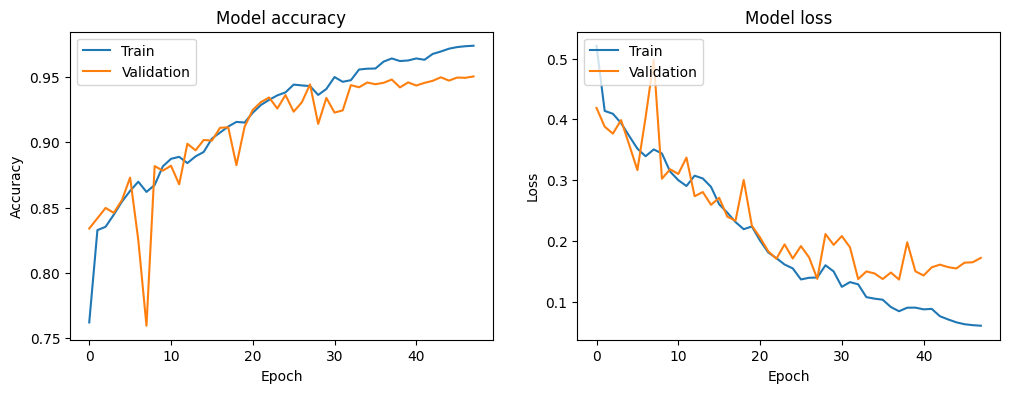

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


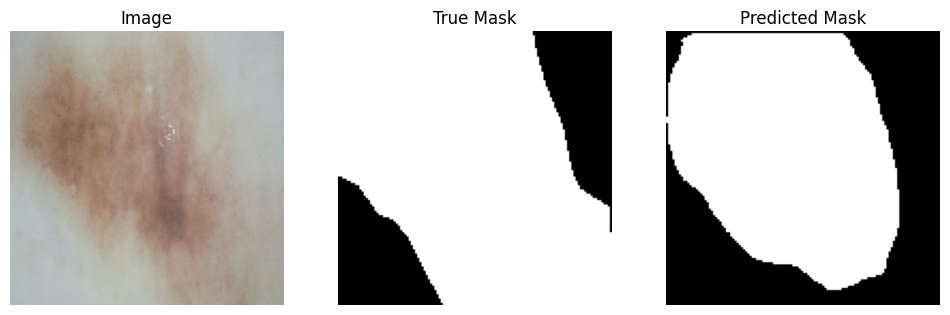

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


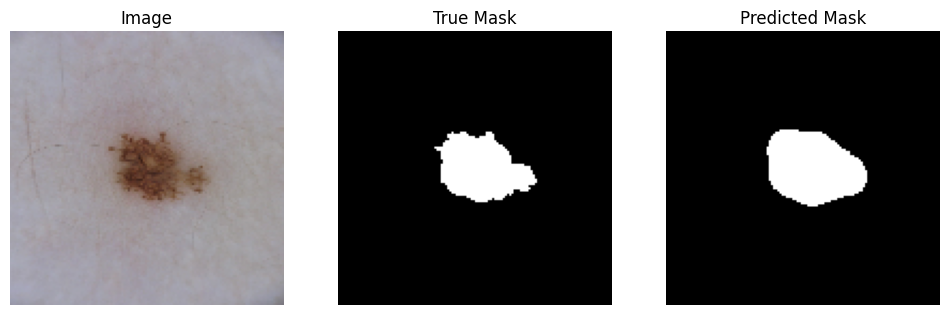

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


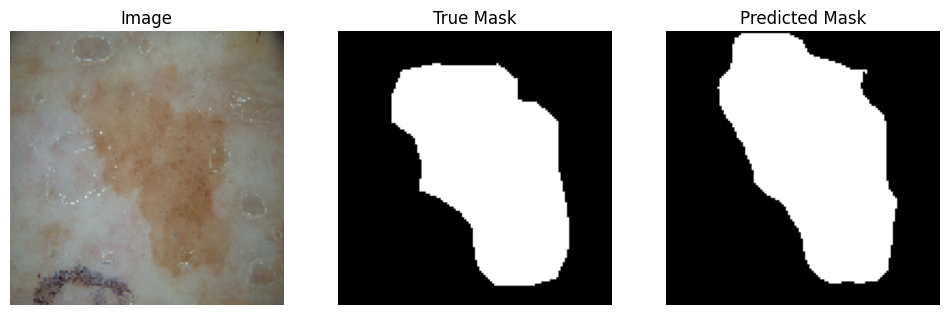

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


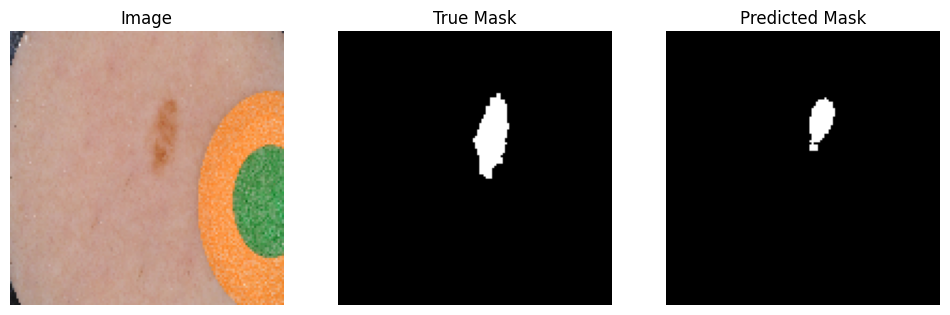

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


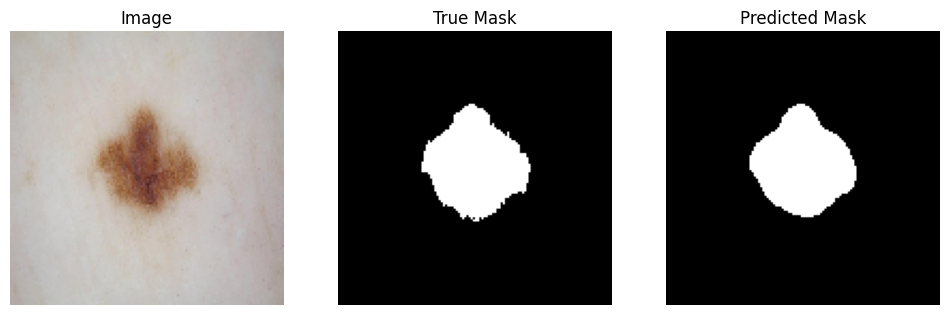

In [ ]:
save_training_history(history_metrics, 'metrics_model', more_metrics=True)

plot_training_history(history_metrics)

visualize_predictions(x_val, y_val, model_metrics)

In [ ]:
# evaluate the model
evaluation = model_metrics.evaluate(x_val, y_val)

print(f"Loss: {evaluation[0]}")
print(f"Accuracy: {evaluation[1]}")
print(f"Sensitivity: {evaluation[2]}")
print(f"Specificity: {evaluation[3]}")
print(f"F1 Score: {evaluation[4]}")
print(f"Jaccard Index: {evaluation[5]}")
print(f"Dice Coefficient: {evaluation[6]}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.9533 - dice_coefficient: 0.8684 - f1_score: 0.9102 - jaccard_index: 0.7790 - loss: 0.1208 - sensitivity: 0.9099 - specificity: 0.9691
Loss: 0.13612599670886993
Accuracy: 0.9481157064437866
Sensitivity: 0.899836540222168
Specificity: 0.9660750031471252
F1 Score: 0.9000175595283508
Jaccard Index: 0.7650230526924133
Dice Coefficient: 0.8582704663276672


# Fine-tuning the network

Now, we will fine-tune the network to make it more performant. To do so we will do :

- Data Augmentation on the original data (was not useful first try but implementation was shit)
  - Rotate, shift, zoom, flip (vertical or horizontal), add gaussian blur
- Parameter Optimization (the original parameter were choosen arbitrarly)
- Preventing overfitting either by L2 regulation or dropout
- Using a different loss function (Dice Coefficient Loss)

# Hyper Parameter Tuning

Here I will try to train different networks, on fewer epochs, with different hyper-parameter like dropout rate, learning rate or batch size to try and find the best combination.

In [ ]:
history_dict = {}

for dropout_rate in [0.1, 0.2, 0.3, 0.4, 0.5]:
    for learning_rate in [0.0001, 0.001, 0.01, 0.1]:
        for batch_size in [8, 16, 32]:
            print(f"Training with dropout_rate={dropout_rate}, learning_rate={learning_rate}, batch_size={batch_size}")
            model_dropout = unet_dropout(input_size=(128, 128, 3), dropout_rate=dropout_rate)
            model_dropout = compile_model_with_metrics(model_dropout, optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
            history = model_dropout.fit(
                x_train, y_train,
                epochs=10,
                batch_size=batch_size,
                validation_data=(x_val, y_val),
                callbacks=callbacks
            )
            history_dict[(dropout_rate, learning_rate, batch_size)] = history.history

# Find the best model based on the Jaccard index
best_jaccard_index = -1
best_params = None

for params, history in history_dict.items():
    max_jaccard_index = max(history['val_jaccard_index'])
    if max_jaccard_index > best_jaccard_index:
        best_jaccard_index = max_jaccard_index
        best_params = params

print(f"Best model parameters: dropout_rate={best_params[0]}, learning_rate={best_params[1]}, batch_size={best_params[2]}")
print(f"Best Jaccard index: {best_jaccard_index}")

# Couldn't get the full hyper-parameter tuning going with Colab kicking me out of the session and stopping it mid-way.

Training with dropout_rate=0.1, learning_rate=0.0001, batch_size=8
Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 52s 228ms/step - accuracy: 0.7178 - dice_coefficient: 0.3137 - f1_score: 0.0708 - jaccard_index: 0.1961 - loss: 0.5861 - sensitivity: 0.0607 - specificity: 0.9810 - val_accuracy: 0.8520 - val_dice_coefficient: 0.4875 - val_f1_score: 0.6159 - val_jaccard_index: 0.3387 - val_loss: 0.3716 - val_sensitivity: 0.4608 - val_specificity: 0.9965
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 0.8769 - dice_coefficient: 0.5798 - f1_score: 0.7250 - jaccard_index: 0.4359 - loss: 0.3289 - sensitivity: 0.6507 - specificity: 0.9619 - val_accuracy: 0.9097 - val_dice_coefficient: 0.6012 - val_f1_score: 0.8101 - val_jaccard_index: 0.4583 - val_loss: 0.2634 - val_sensitivity: 0.7385 - val_specificity: 0.9771
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 21s 145ms/step - accuracy: 0.9005 - dice_coefficient: 0.6602 - f1_score: 0.8034 - jaccard_index: 0.5242 - loss: 0.2667 - sensitivity: 0.7621 

KeyboardInterrupt: 

### Class Weight Calculation

Since the masks are mostly composed of background, the model might be biased towards predicting the background class. To address this issue, we can calculate the class weights and use them during training to give more importance to the melanoma class.



In [ ]:
all_pixels = []

for mask_file in os.listdir(mask_dir):
    mask_path = os.path.join(mask_dir, mask_file)
    mask = load_img(mask_path, target_size=img_size, color_mode="grayscale")
    mask = img_to_array(mask) / 255.0
    mask = np.round(mask).astype(np.uint8)
    all_pixels.extend(mask.flatten())

all_pixels = np.array(all_pixels)
# Compute the weights of the class
sample_weights = compute_class_weight(class_weight='balanced', classes=np.unique(all_pixels), y=all_pixels)

class_weights = {
    0: sample_weights[0],
    1: sample_weights[1]
}

# Normalize the class weights so that their sum equals 1
total_weight = class_weights[0] + class_weights[1]
class_weights[0] = class_weights[0] / total_weight
class_weights[1] = class_weights[1] / total_weight

print(class_weights)

{0: 0.2709379069010417, 1: 0.7290620930989583}


In [ ]:
# Train the network with class weights
model = unet_model(input_size=(128, 128, 3))

# To get the weight to matter, let's define a custom weighted binary crossentropy loss function
def weighted_binary_crossentropy(pos_weight, neg_weight):
    def loss(y_true, y_pred):
        # Clip predictions to prevent log(0)
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())

        # Calculate the binary cross-entropy loss
        bce = - (pos_weight * y_true * K.log(y_pred) + neg_weight * (1 - y_true) * K.log(1 - y_pred))

        return K.mean(bce)

    return loss

# Define class weights
pos_weight = class_weights[1]  # Weight for positive class (cancerous)
neg_weight = class_weights[0]  # Weight for negative class (non-cancerous)

# Create the custom loss function
custom_loss = weighted_binary_crossentropy(pos_weight, neg_weight)

In [ ]:
# Define callbacks
callbacks_weighted = [
    ModelCheckpoint("melanoma_segmentation_weighted.keras", save_best_only=True),
    EarlyStopping(patience=10, restore_best_weights=True)
]

In [ ]:
# Testing the weighted approach with the more metrics

model_weighted = unet_model(input_size=(128, 128, 3))
model_weighted = compile_model_with_metrics(model_weighted, optimizer='adam', loss=custom_loss)

history_weighted = model_weighted.fit(
    x_train, y_train,
    epochs=100,
    batch_size=16,
    validation_data=(x_val, y_val),
    callbacks=callbacks_weighted
)

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 25s 350ms/step - accuracy: 0.6933 - dice_coefficient: 0.4008 - f1_score: 0.5716 - jaccard_index: 0.2716 - loss: 0.2510 - sensitivity: 0.7360 - specificity: 0.6748 - val_accuracy: 0.6551 - val_dice_coefficient: 0.4527 - val_f1_score: 0.5595 - val_jaccard_index: 0.3217 - val_loss: 0.2392 - val_sensitivity: 0.8890 - val_specificity: 0.5510
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 22s 484ms/step - accuracy: 0.7555 - dice_coefficient: 0.4644 - f1_score: 0.6312 - jaccard_index: 0.3281 - loss: 0.2278 - sensitivity: 0.7438 - specificity: 0.7640 - val_accuracy: 0.7755 - val_dice_coefficient: 0.5533 - val_f1_score: 0.6300 - val_jaccard_index: 0.4159 - val_loss: 0.2139 - val_sensitivity: 0.7757 - val_specificity: 0.7597
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 38s 410ms/step - accuracy: 0.7939 - dice_coefficient: 0.5176 - f1_score: 0.6860 - jaccard_index: 0.3782 - loss: 0.2077 - sensitivity: 0.7769 - specificity: 0.8023 - val_accuracy: 0.7393 - val_dice_coeffici

In [ ]:
model_weighted.save('/content/melanoma_segmentation_weighted_metrics.keras')

Training history saved to /content/csv/weighted_metrics_model_20241019_154549.csv


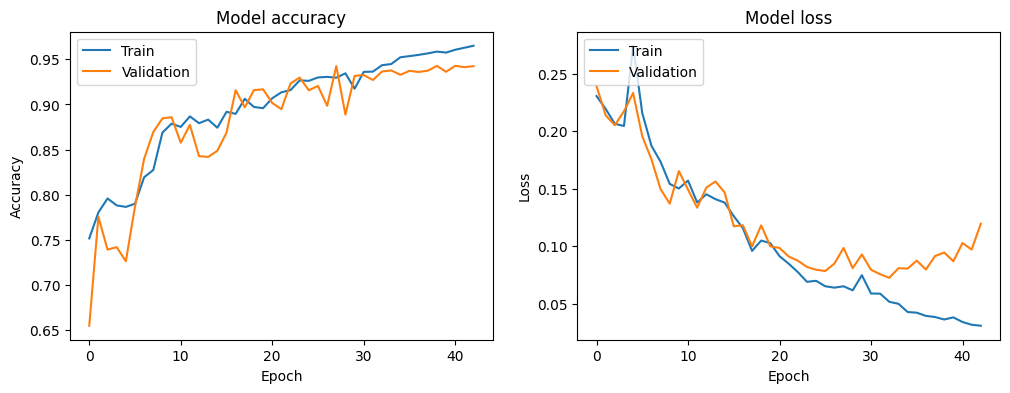

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


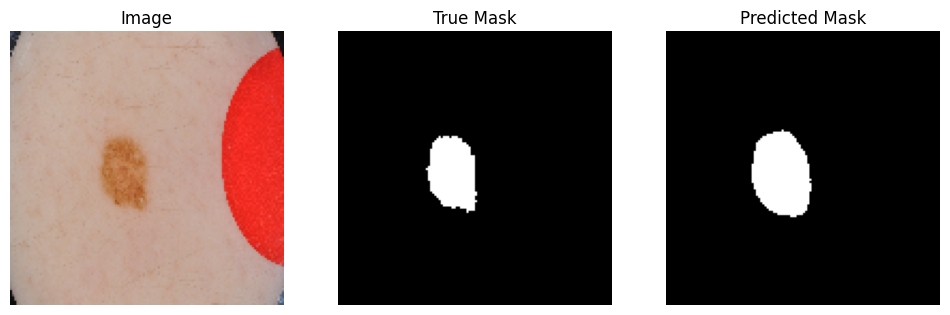

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


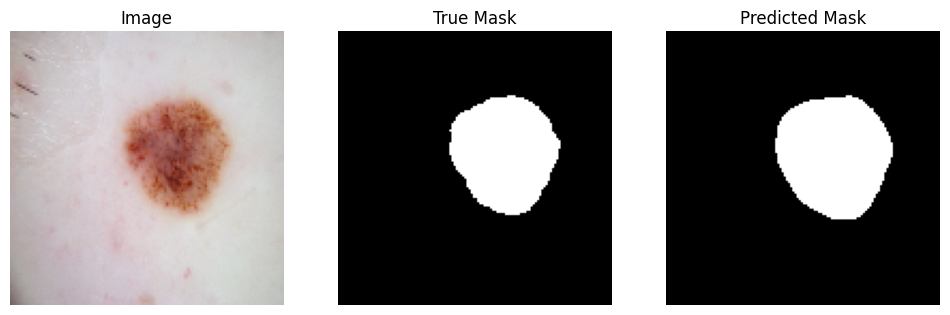

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


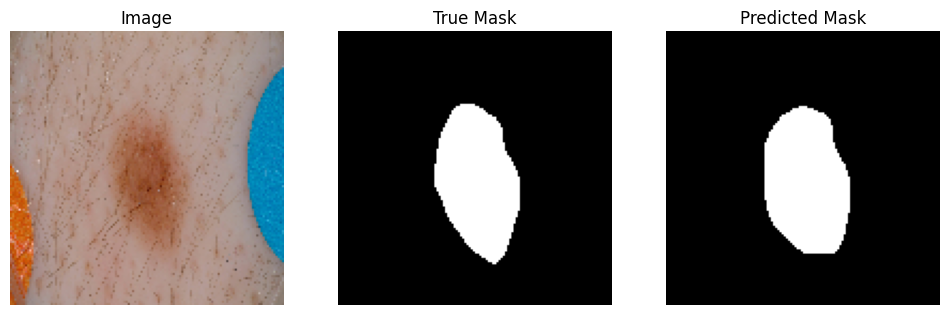

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


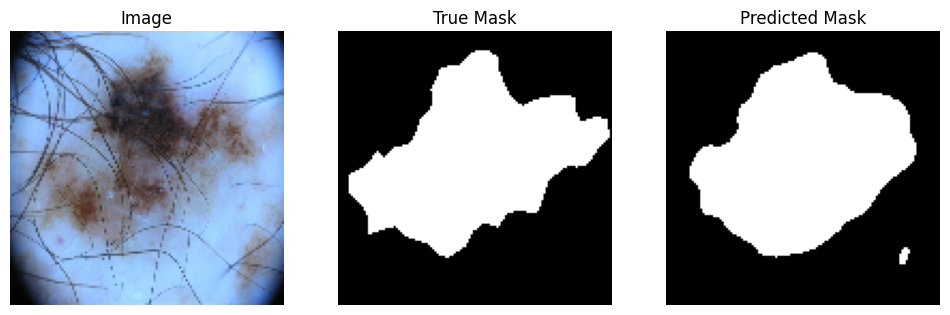

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


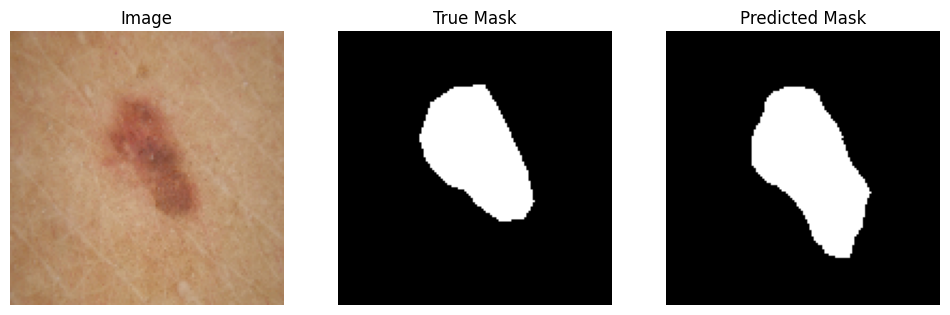

In [ ]:
save_training_history(history_weighted, 'weighted_metrics_model', more_metrics=True)

plot_training_history(history_weighted)

visualize_predictions(x_val, y_val, model_weighted)

In [ ]:
# evaluate the model

evaluation = model_weighted.evaluate(x_val, y_val)

print(f"Loss: {evaluation[0]}")
print(f"Accuracy: {evaluation[1]}")
print(f"Sensitivity: {evaluation[2]}")
print(f"Specificity: {evaluation[3]}")
print(f"F1 Score: {evaluation[4]}")
print(f"Jaccard Index: {evaluation[5]}")
print(f"Dice Coefficient: {evaluation[6]}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 285ms/step - accuracy: 0.9419 - dice_coefficient: 0.8338 - f1_score: 0.8947 - jaccard_index: 0.7303 - loss: 0.0643 - sensitivity: 0.9440 - specificity: 0.9419
Loss: 0.07261323183774948
Accuracy: 0.9363837242126465
Sensitivity: 0.934116780757904
Specificity: 0.9390996098518372
F1 Score: 0.8846287727355957
Jaccard Index: 0.7144449353218079
Dice Coefficient: 0.8217841982841492


### Dropout Layered U-Net Network

Another approach I want to try is to add Dropout layers in the U-Net architecture, as the plots from the baseline showed a small overfitting of the model.


In [ ]:
def unet_dropout(input_size=(256, 256, 3), dropout_rate=0.5):
    inputs = tf.keras.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    p1 = layers.Dropout(dropout_rate)(p1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    p2 = layers.Dropout(dropout_rate)(p2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    p3 = layers.Dropout(dropout_rate)(p3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)
    p4 = layers.Dropout(dropout_rate)(p4)

    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    c5 = layers.Dropout(dropout_rate)(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    c6 = layers.Dropout(dropout_rate)(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    c7 = layers.Dropout(dropout_rate)(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    c8 = layers.Dropout(dropout_rate)(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    c9 = layers.Dropout(dropout_rate)(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model


In [ ]:
# Define callbacks
callbacks_dropout128 = [
    ModelCheckpoint("melanoma_segmentation_weighted.keras", save_best_only=True),
    EarlyStopping(patience=20, restore_best_weights=True)
]

In [ ]:
model_dropout128 = unet_dropout(input_size=(128,128,3), dropout_rate=0.25)
model_dropout128 = compile_model_with_metrics(model_dropout128)

# Train the dropout model
history_dropout128 = model_dropout128.fit(
    x_train, y_train,
    epochs=100,
    batch_size=16,
    validation_data=(x_val, y_val),
    callbacks=callbacks_dropout128
)

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 32s 361ms/step - accuracy: 0.7173 - dice_coefficient: 0.3212 - f1_score: 0.2402 - jaccard_index: 0.2007 - loss: 0.5383 - sensitivity: 0.2504 - specificity: 0.8983 - val_accuracy: 0.8201 - val_dice_coefficient: 0.3892 - val_f1_score: 0.5261 - val_jaccard_index: 0.2534 - val_loss: 0.4267 - val_sensitivity: 0.3870 - val_specificity: 0.9724
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 26s 239ms/step - accuracy: 0.8388 - dice_coefficient: 0.4475 - f1_score: 0.6352 - jaccard_index: 0.3049 - loss: 0.4172 - sensitivity: 0.5490 - specificity: 0.9499 - val_accuracy: 0.8183 - val_dice_coefficient: 0.4429 - val_f1_score: 0.6551 - val_jaccard_index: 0.3024 - val_loss: 0.4311 - val_sensitivity: 0.6812 - val_specificity: 0.8610
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 306ms/step - accuracy: 0.8344 - dice_coefficient: 0.4936 - f1_score: 0.6703 - jaccard_index: 0.3466 - loss: 0.4198 - sensitivity: 0.6047 - specificity: 0.9292 - val_accuracy: 0.8378 - val_dice_coeffici

In [ ]:
model_dropout128.save('/content/melanoma_segmentation_dropout.keras')

Training history saved to /content/csv/dropout_model_20241019_184524.csv


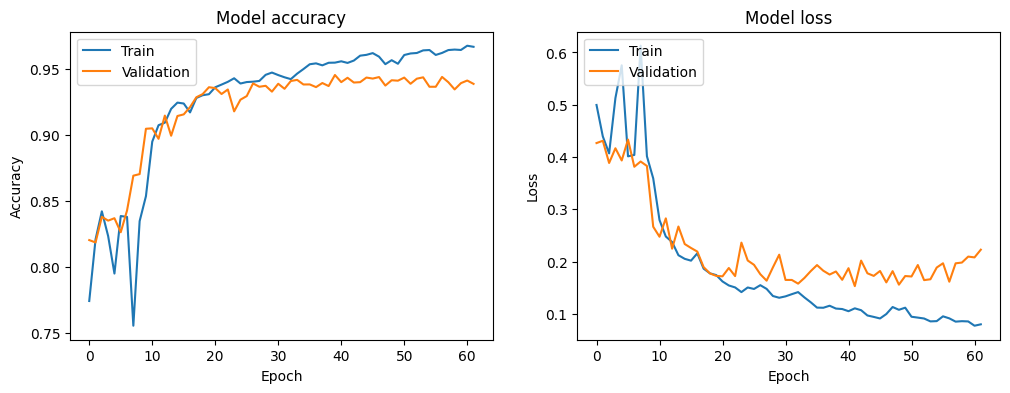

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


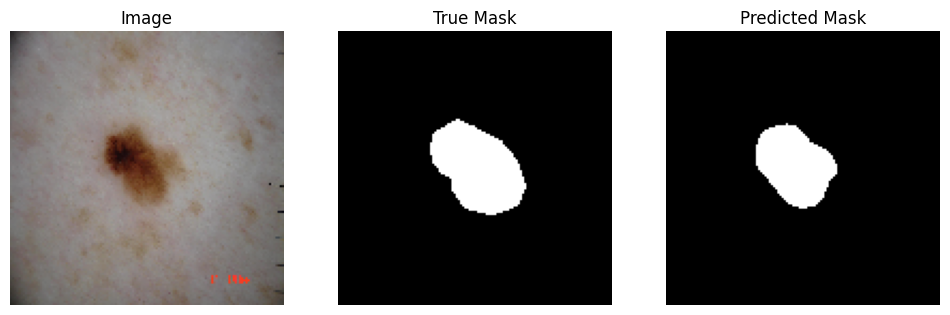

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


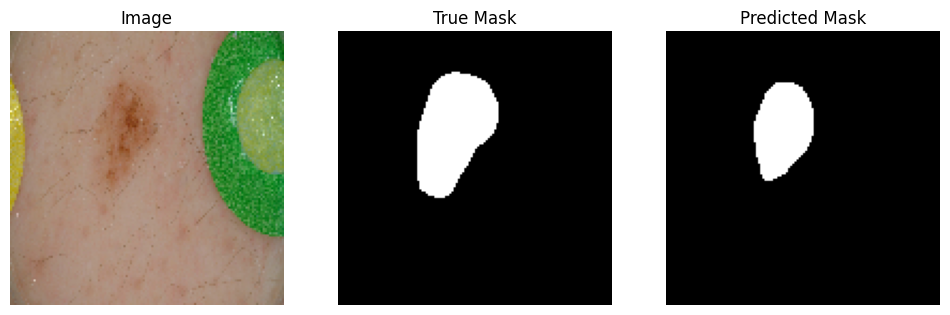

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


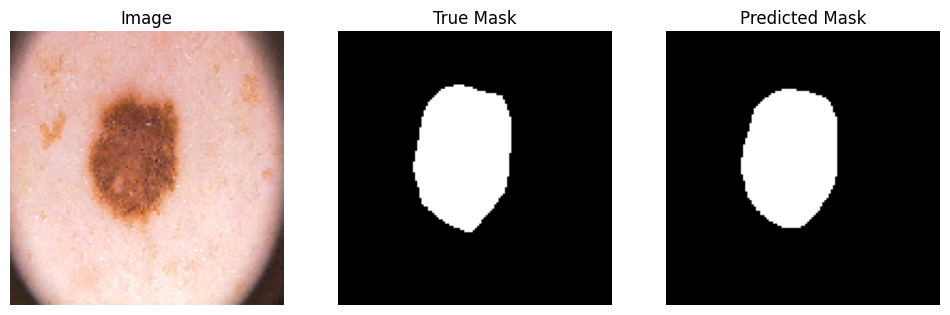

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


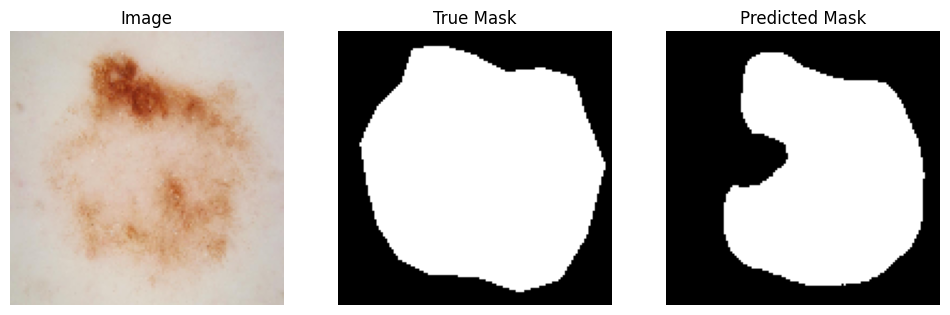

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


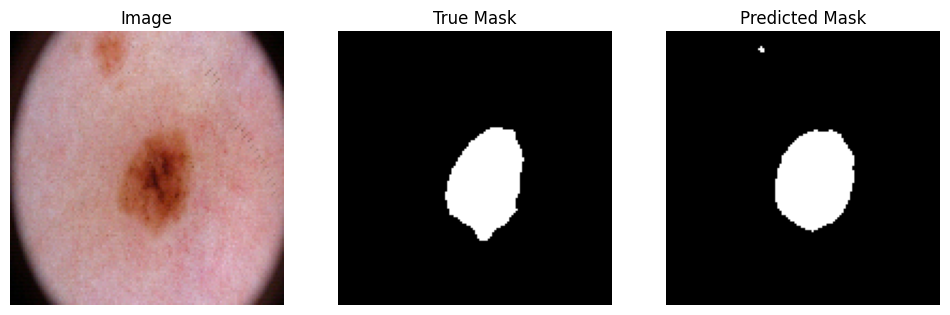

In [ ]:
# Save the training history
save_training_history(history_dropout128, 'dropout_model', more_metrics=True)

# Plot the training history
plot_training_history(history_dropout128)

# Visualize predictions
visualize_predictions(x_val, y_val, model_dropout128)


In [ ]:
# evaluate the model

evaluation = model_dropout128.evaluate(x_val, y_val)

print(f"Loss: {evaluation[0]}")
print(f"Accuracy: {evaluation[1]}")
print(f"Sensitivity: {evaluation[2]}")
print(f"Specificity: {evaluation[3]}")
print(f"F1 Score: {evaluation[4]}")
print(f"Jaccard Index: {evaluation[5]}")
print(f"Dice Coefficient: {evaluation[6]}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.9498 - dice_coefficient: 0.8328 - f1_score: 0.8983 - jaccard_index: 0.7272 - loss: 0.1327 - sensitivity: 0.8541 - specificity: 0.9840
Loss: 0.15306247770786285
Accuracy: 0.9430806636810303
Sensitivity: 0.836117684841156
Specificity: 0.9815575480461121
F1 Score: 0.884319007396698
Jaccard Index: 0.7081137299537659
Dice Coefficient: 0.818455696105957


### Data Augmentation Techniques

Last but not least, I will try to add some "On the fly" data augmentation to make the dataset virtually bigger and thus make the model more robust.

In [ ]:
img_size = (128, 128)

images, masks = load_images(image_dir, mask_dir, img_size)
x_train, x_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=10,  # Reduce rotation range
    width_shift_range=0.05,  # Reduce shift range
    height_shift_range=0.05,
    shear_range=0.05,  # Reduce shear range
    zoom_range=0.05,  # Reduce zoom range
    horizontal_flip=True,  # Keep horizontal flip
    fill_mode='nearest'
)

In [ ]:
train_generator = datagen.flow(
    x_train, y_train,
    batch_size=16,
    seed=42  # Set a seed for reproducibility
)

In [ ]:
# Define callbacks
callbacks_data = [
    ModelCheckpoint("melanoma_segmentation_weighted.keras", save_best_only=True),
    EarlyStopping(patience=10, restore_best_weights=True)
]

In [ ]:
# Create and compile the data model
model_data = unet_model(input_size=(128,128,3))
model_data = compile_model_with_metrics(model_data)

history_data = model_data.fit(
    train_generator,
    epochs=100,
    validation_data=(x_val,y_val),
    callbacks=callbacks_data
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


45/45 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.7059 - dice_coefficient: 0.2893 - f1_score: 0.1304 - jaccard_index: 0.1768 - loss: 0.5695 - sensitivity: 0.1456 - specificity: 0.9251 - val_accuracy: 0.8102 - val_dice_coefficient: 0.3641 - val_f1_score: 0.4809 - val_jaccard_index: 0.2317 - val_loss: 0.4312 - val_sensitivity: 0.3391 - val_specificity: 0.9762
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 952ms/step - accuracy: 0.7864 - dice_coefficient: 0.3802 - f1_score: 0.5351 - jaccard_index: 0.2472 - loss: 0.4985 - sensitivity: 0.4479 - specificity: 0.9294 - val_accuracy: 0.8288 - val_dice_coefficient: 0.4338 - val_f1_score: 0.5671 - val_jaccard_index: 0.2931 - val_loss: 0.4006 - val_sensitivity: 0.4293 - val_specificity: 0.9704
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 50s 217ms/step - accuracy: 0.7681 - dice_coefficient: 0.3766 - f1_score: 0.4561 - jaccard_index: 0.2466 - loss: 0.7655 - sensitivity: 0.4051 - specificity: 0.9154 - val_accuracy: 0.8327 - val_dice_coefficient: 0.4052 - v

In [ ]:
model.save('/content/melanoma_segmentation_data.keras')

Training history saved to /content/csv/data_20241019_165017.csv


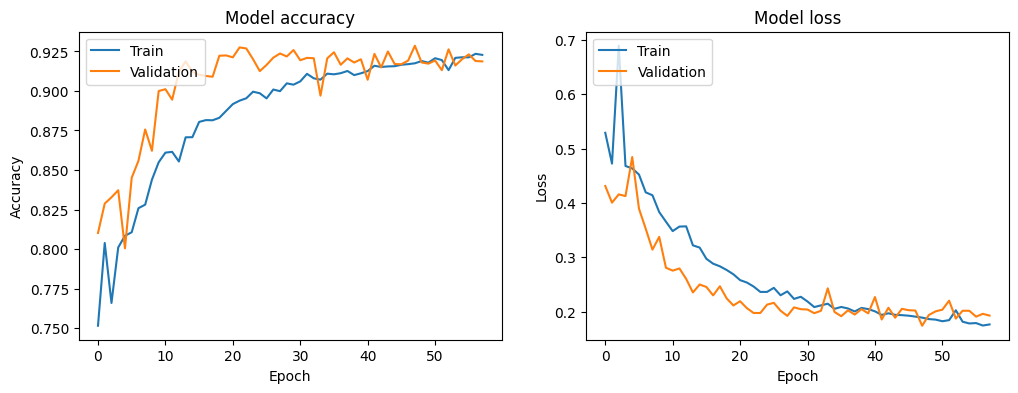

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step


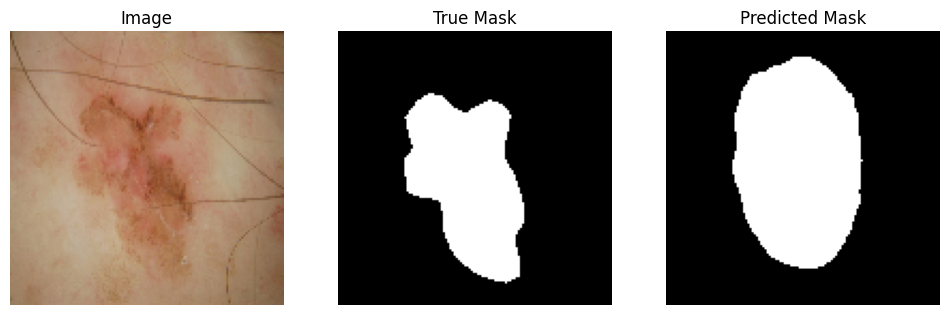

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


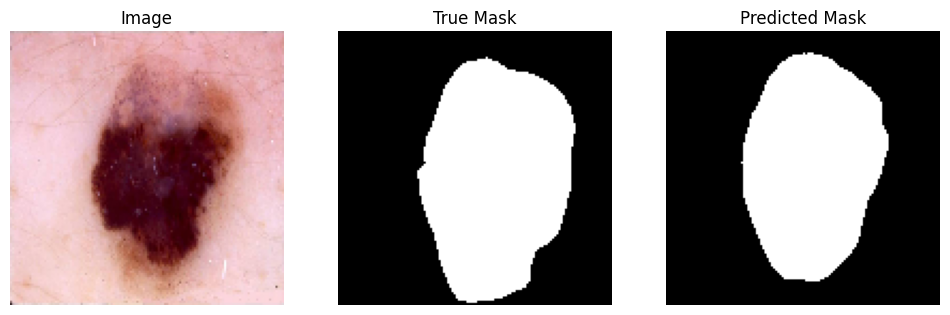

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


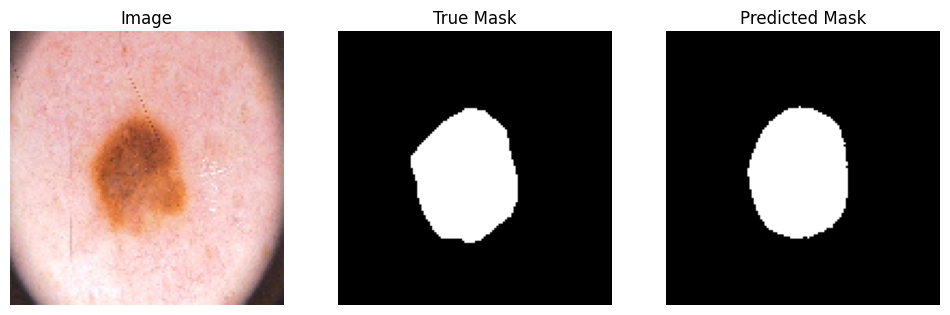

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


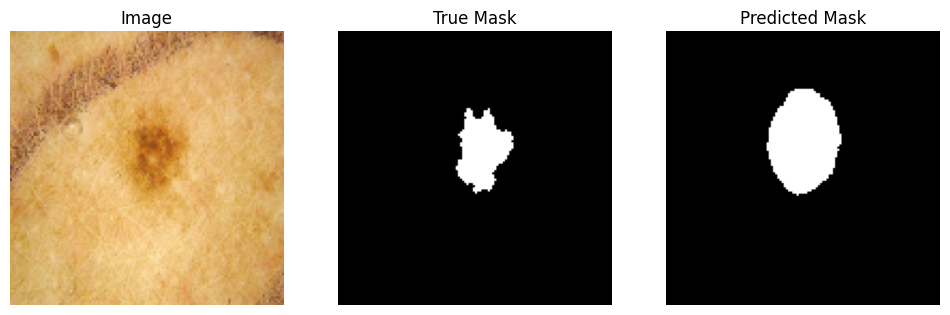

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


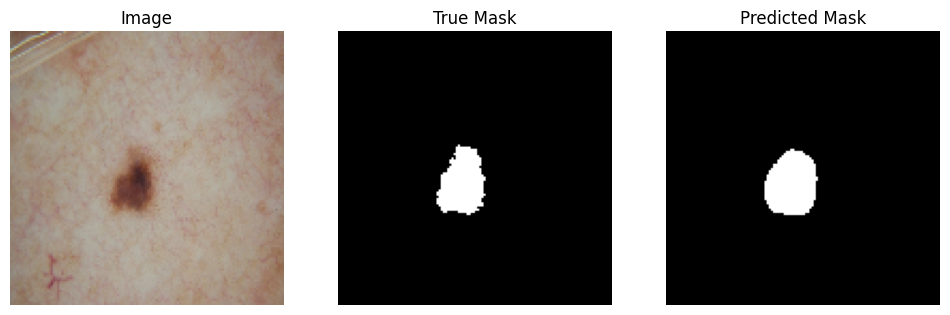

In [ ]:
# Save the training history
save_training_history(history_data, 'data', more_metrics=True)

# Plot the training history
plot_training_history(history_data)

# Visualize predictions
visualize_predictions(x_val, y_val, model_data)


In [ ]:
# evaluate the model

evaluation = model_data.evaluate(x_val, y_val)

print(f"Loss: {evaluation[0]}")
print(f"Accuracy: {evaluation[1]}")
print(f"Sensitivity: {evaluation[2]}")
print(f"Specificity: {evaluation[3]}")
print(f"F1 Score: {evaluation[4]}")
print(f"Jaccard Index: {evaluation[5]}")
print(f"Dice Coefficient: {evaluation[6]}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.9328 - dice_coefficient: 0.7595 - f1_score: 0.8657 - jaccard_index: 0.6267 - loss: 0.1634 - sensitivity: 0.8313 - specificity: 0.9692
Loss: 0.17425520718097687
Accuracy: 0.9286133050918579
Sensitivity: 0.8253951072692871
Specificity: 0.9662505984306335
F1 Score: 0.8578184247016907
Jaccard Index: 0.6133509874343872
Dice Coefficient: 0.748437225818634


### Data Augmentation with Class Weights

Last model I'll try is a combination of Data Augmentation and Class Weights, with dropout as well.


In [ ]:
# Define callbacks
callbacks_data_w = [
    ModelCheckpoint("melanoma_segmentation_data_weighted.keras", save_best_only=True),
    EarlyStopping(patience=20, restore_best_weights=True)
]

In [ ]:
model_data_weighted = unet_dropout(input_size=(128,128,3), dropout_rate=0.25)
model_data_weighted = compile_model_with_metrics(model_data_weighted, optimizer='adam', loss=custom_loss)

history_data_w = model_data_weighted.fit(
    train_generator,
    epochs=100,
    validation_data=(x_val,y_val),
    callbacks=callbacks_data_w
)

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 32s 299ms/step - accuracy: 0.6791 - dice_coefficient: 0.3497 - f1_score: 0.4242 - jaccard_index: 0.2263 - loss: 0.2595 - sensitivity: 0.5022 - specificity: 0.7553 - val_accuracy: 0.8289 - val_dice_coefficient: 0.4176 - val_f1_score: 0.6610 - val_jaccard_index: 0.2814 - val_loss: 0.1980 - val_sensitivity: 0.6503 - val_specificity: 0.8913
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 569ms/step - accuracy: 0.7754 - dice_coefficient: 0.4107 - f1_score: 0.6055 - jaccard_index: 0.2795 - loss: 0.2198 - sensitivity: 0.6615 - specificity: 0.8164 - val_accuracy: 0.8359 - val_dice_coefficient: 0.4804 - val_f1_score: 0.7076 - val_jaccard_index: 0.3394 - val_loss: 0.1721 - val_sensitivity: 0.7801 - val_specificity: 0.8542
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 39s 528ms/step - accuracy: 0.7663 - dice_coefficient: 0.4628 - f1_score: 0.6450 - jaccard_index: 0.3261 - loss: 0.2033 - sensitivity: 0.7560 - specificity: 0.7667 - val_accuracy: 0.8208 - val_dice_coeffici

In [ ]:
model_data_weighted.save('/content/melanoma_segmentation_data_w.keras')

Training history saved to /content/csv/data_20241019_192453.csv


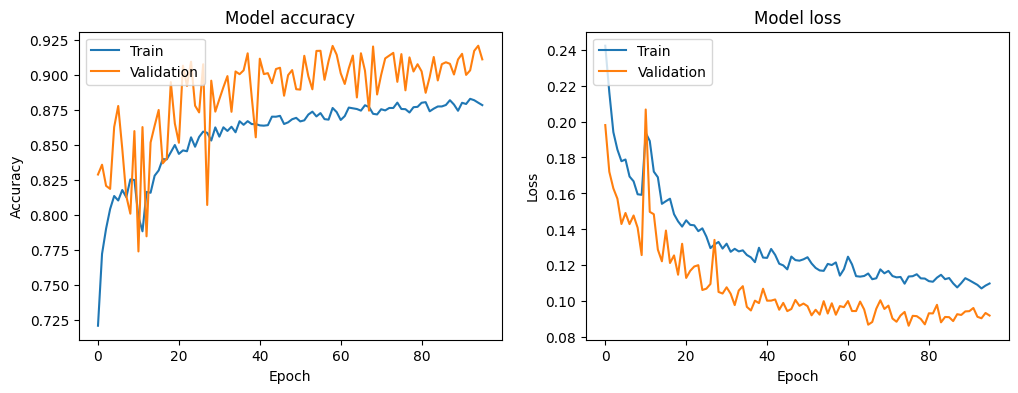

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step


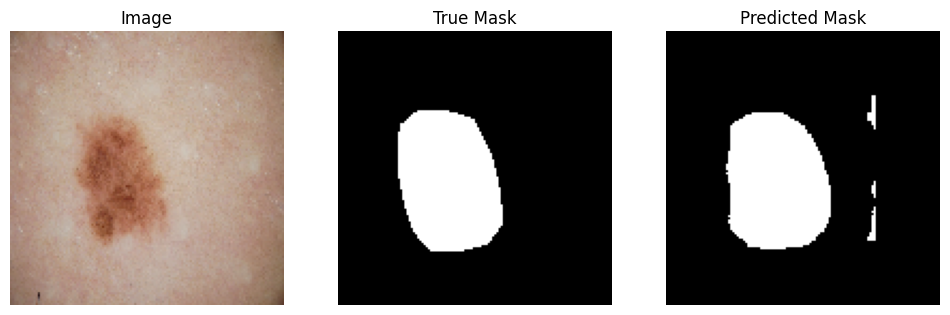

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


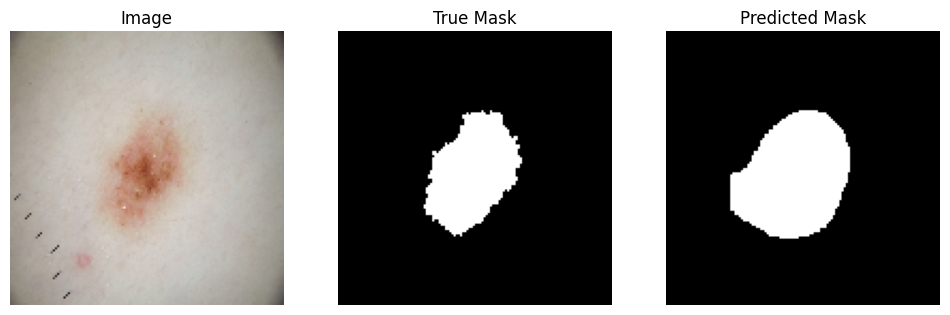

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


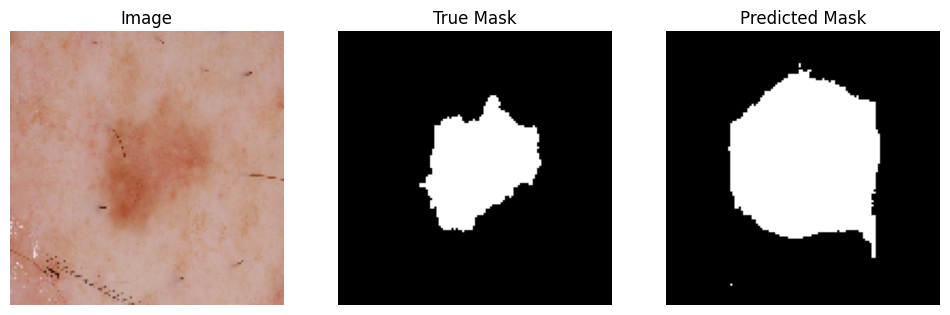

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


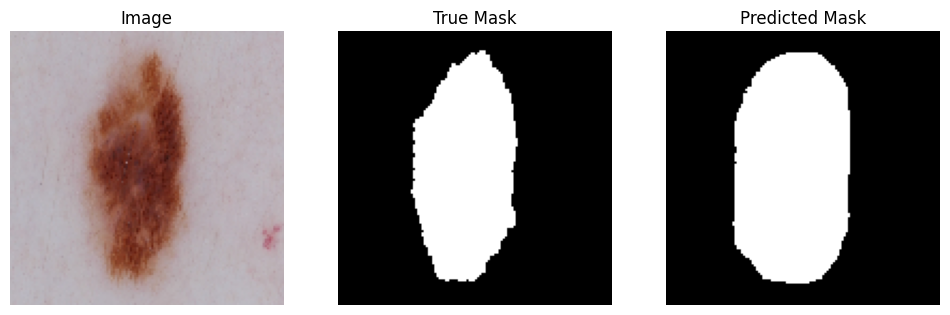

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


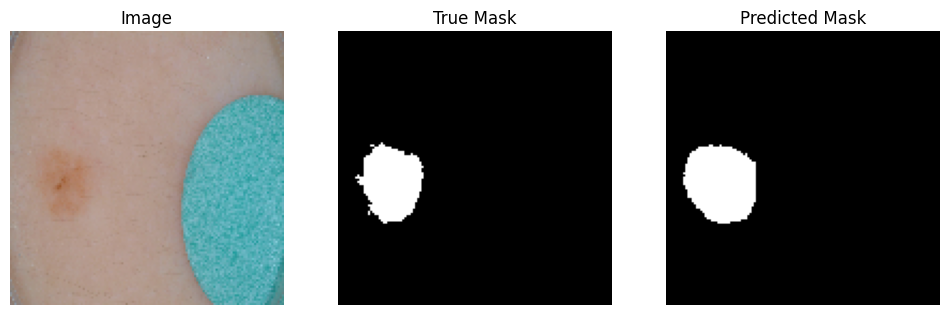

In [ ]:
# Save the training history
save_training_history(history_data_w, 'data', more_metrics=True)

# Plot the training history
plot_training_history(history_data_w)

# Visualize predictions
visualize_predictions(x_val, y_val, model_data_weighted)


In [ ]:
# evaluate the model

evaluation = model_data_weighted.evaluate(x_val, y_val)

print(f"Loss: {evaluation[0]}")
print(f"Accuracy: {evaluation[1]}")
print(f"Sensitivity: {evaluation[2]}")
print(f"Specificity: {evaluation[3]}")
print(f"F1 Score: {evaluation[4]}")
print(f"Jaccard Index: {evaluation[5]}")
print(f"Dice Coefficient: {evaluation[6]}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.9206 - dice_coefficient: 0.7358 - f1_score: 0.8586 - jaccard_index: 0.6000 - loss: 0.0785 - sensitivity: 0.9300 - specificity: 0.9177
Loss: 0.0864139050245285
Accuracy: 0.9150380492210388
Sensitivity: 0.9176028370857239
Specificity: 0.9158211350440979
F1 Score: 0.8471327424049377
Jaccard Index: 0.5830309391021729
Dice Coefficient: 0.7202300429344177


# Results comparision :

Now I'll make a table with the results of each model and the metrics used in the study :

### Model Performance Comparison

| Metric               | Baseline       | Class Weight   | Dropout        | Data Augmentation   | Combination       |
|----------------------|----------------|----------------|----------------|---------------------|-------------------|
| **Loss**             | 0.1361         | **0.0726**     | 0.1531         | 0.1743              | 0.0864            |
| **Accuracy**         | **0.9481**     | 0.9364         | 0.9431         | 0.9286              | 0.9150            |
| **Sensitivity**      | 0.8998         | **0.9341**     | 0.8361         | 0.8254              | 0.9176            |
| **Specificity**      | 0.9661         | 0.9391         | **0.9816**     | 0.9663              | 0.9158            |
| **F1 Score**         | **0.9000**     | 0.8846         | 0.8843         | 0.8578              | 0.8471            |
| **Jaccard Index**    | **0.7650**     | 0.7144         | 0.7081         | 0.6134              | 0.5830            |
| **Dice Coefficient** | **0.8583**     | 0.8218         | 0.8185         | 0.7484              | 0.7202            |

From the table, we can observe that the baseline model generally outperforms the others, particularly in terms of the Jaccard Index, where no alternative approach comes close. However, the "Class Weight" model, designed to address class imbalance, shows the lowest loss and the highest sensitivity, indicating it effectively improves the detection of the minority class. The Dropout model achieves the highest specificity, suggesting it excels at reducing false positives. Interestingly, despite combining various techniques, the "Combination" and "Data Augmentation" models perform below expectations, emphasizing that more complex models don't always lead to better outcomes.

I was surprised that the data augmentation approach didn't improve the results, as it's widely used in the literature and is generally effective at boosting model performance, particularly with smaller datasets like this one. It's possible there were issues with my implementation that I couldn't identify but I also used the most used approach when using Keras... Frankly, I'm a bit disappointed that I couldn't consistently outperform the baseline model across all metrics, despite trying various techniques. Some of these experiments aren't included here because they didn't yield meaningful results, but I also explored using a custom "Dice Coefficient Loss" function and a weighted version of that loss function.

The Jupyter Notebook includes all the training processes I ran, along with plots showing the evolution of accuracy and loss for each model. I've also added visualizations of the models' predictions on a few sample images. These predictions align well with the metrics in the table: the Class Weight model often overestimates the size of the mask, while the Dropout model tends to underestimate it. As for the Data Augmentation model, its predictions are generally more inconsistent and slightly off overall.